<a href="https://colab.research.google.com/github/abhinavchawla13/SwimmingPool-Detection/blob/master/Detectron_Prepare_Own_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Sample format
```
[
  {'annotations': [{'bbox': [994, 619, 1445, 1166],
   'bbox_mode': 'XYXY_ABS',
   'category_id': 0,
   'segmentation': [[1020.5,
     963.5,
      .
      .
      .
     1032.5,
     989.5,
     1020.5,
     963.5]]}],
  'file_name': 'balloon/train/34020010494_e5cb88e1c4_k.jpg',
  'height': 1536,
  'image_id': 0,
  'width': 2048
  }
]
 ```

In [85]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import os
import cv2 as cv
from pprint import pprint
import json
from tqdm import tqdm

In [2]:
cd detectron/

/Users/abhinav/Documents/Extra/deeplearning/detectron


In [3]:
class_df = pd.read_csv("class-descriptions-boxable.csv", header=None)
class_df.head(5)

,0,1
0,/m/011k07,Tortoise
1,/m/011q46kg,Container
2,/m/012074,Magpie
3,/m/0120dh,Sea turtle
4,/m/01226z,Football


In [90]:
ann_df = pd.read_csv("train-annotations-bbox.csv")
ann_df.head(5)
ann_df.shape

(204621, 13)

In [91]:
#Input - class-descriptions-boxable.csv, list of classnames
#Output - list of labels
# class_description_file is pandas df
def get_label_names(class_df, classnames=[]):
  label_names = {}
  for name in classnames:
    row = class_df.loc[class_df[1] == name]
    label_names[name] = row.iloc[0][0]
  return label_names

In [92]:
classnames = ["Swimming pool"]
label_names = get_label_names(class_df, classnames)
list(label_names.values())

['/m/0b_rs']

In [93]:
filtered_ann_df = ann_df[ann_df['LabelName'].isin(list(label_names.values()))]
filtered_ann_df.head(5)
filtered_ann_df.shape

(142, 13)

In [94]:
COLORS = ['r', 'g', 'b']
# bbox_list will contain list of normalized bbox dicts
def show_image(image_dir, bbox_list_by_class=None):
  img = cv.imread(image_dir)
  # if (bbox_list and len(bbox_list) > 0):
  #   for idx, classname in enumerate(bbox_list_by_class):
  #     for bbox in bbox_list_by_class[classname]:
  #       plt.gca().add_patch(Rectangle((bbox["X"], bbox["Y"]),
  #                                     bbox["w"], bbox["h"], 
  #                                     linewidth=4, edgecolor=COLORS[idx], 
  #                                     facecolor='none'))
  plt.imshow(img)

### Get all annotations per image

In [95]:
def filter_info_by_image(image_id, ann_df):
  anns_for_image = ann_df.loc[ann_df['ImageID'] == image_id]
  return anns_for_image

In [15]:
anns_for_image = filter_info_by_image('000be0d53bf53d3d', ann_df)
anns_for_image

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,IsGroupOf,IsDepiction,IsInside
15344,000be0d53bf53d3d,xclick,/m/04hgtk,1,0.410000,0.515625,0.427778,0.634444,0,0,0,0,0
15345,000be0d53bf53d3d,xclick,/m/05r655,1,0.296875,0.612500,0.416667,0.845556,1,0,0,0,1
15346,000be0d53bf53d3d,xclick,/m/09j2d,1,0.361250,0.562500,0.526667,0.677778,1,0,0,0,0
15347,000be0d53bf53d3d,xclick,/m/0b_rs,1,0.000000,0.999375,0.000000,0.851111,0,0,0,0,0


In [96]:
all_images = filtered_ann_df["ImageID"].values
all_images.shape

(142,)

### Run through images to get annotations

```
[
  {'annotations': [{'bbox': [994, 619, 1445, 1166],
   'bbox_mode': 'XYXY_ABS',
   'category_id': 0,
   'segmentation': [[1020.5,
     963.5,
      .
      .
      .
     1032.5,
     989.5,
     1020.5,
     963.5]]}],
  'file_name': 'balloon/train/34020010494_e5cb88e1c4_k.jpg',
  'height': 1536,
  'image_id': 0,
  'width': 2048
  }
]
 ```

In [52]:
def get_unnormalized(height, width, normalized_values):
  
  X = normalized_values["XMin"] * width
  Y = normalized_values["YMin"] * height
  w = (normalized_values["XMax"] - normalized_values["XMin"]) * width
  h = (normalized_values["YMax"] - normalized_values["YMin"]) * height
  

  return {"X": X, "Y": Y, "w": w, "h": h}  

In [112]:
def prepare_train_json():
  train_data = []
  for img_id in tqdm(all_images):
    img_data = {}
    
    img_data["file_name"] = os.path.join("validation", img_id + ".jpg")
    img_data["image_id"] = img_id

    img = cv.imread(img_data["file_name"])
    img_data["height"], img_data["width"], _ = img.shape
    img_data["annotations"] = []
    
    anns_for_image = filter_info_by_image(img_id, filtered_ann_df)
    for index, row in anns_for_image.iterrows():
      ann_info = {}
      normalized_values = {
            "XMin": row["XMin"],
            "XMax": row["XMax"],
            "YMin": row["YMin"],
            "YMax": row["YMax"]
      }
      unnormalized_values = get_unnormalized(img_data["height"],
                                            img_data["width"],
                                            normalized_values)
      
      ann_info["bbox"] = list(unnormalized_values.values())
      #XYWH_ABS = 1
      ann_info["bbox_mode"] = BoxMode.XYWH_ABS
      # only one category
      ann_info["category_id"] = 0
      # skipping segmentation values

      img_data["annotations"].append(ann_info)

    train_data.append(img_data)
  return train_data

### create train json

In [115]:
train_data = prepare_train_json()
len(train_data)
train_data

100%|██████████| 142/142 [00:01<00:00, 75.53it/s]


[{'file_name': 'validation/00f3dbbbf5bdf2cf.jpg',
  'image_id': '00f3dbbbf5bdf2cf',
  'height': 768,
  'width': 768,
  'annotations': [{'bbox': [203.30188800000002,
     375.046656,
     564.698112,
     141.009408],
    'bbox_mode': <BoxMode.XYWH_ABS: 1>,
    'category_id': 0}]},
 {'file_name': 'validation/019347cc4772963d.jpg',
  'image_id': '019347cc4772963d',
  'height': 758,
  'width': 1024,
  'annotations': [{'bbox': [0.0,
     413.9832160000001,
     1024.0,
     343.90914799999996],
    'bbox_mode': <BoxMode.XYWH_ABS: 1>,
    'category_id': 0}]},
 {'file_name': 'validation/044b153ff1b17c28.jpg',
  'image_id': '044b153ff1b17c28',
  'height': 634,
  'width': 1024,
  'annotations': [{'bbox': [0.0, 277.94243, 1024.0, 356.05757],
    'bbox_mode': <BoxMode.XYWH_ABS: 1>,
    'category_id': 0}]},
 {'file_name': 'validation/0bb341c20b9978cf.jpg',
  'image_id': '0bb341c20b9978cf',
  'height': 768,
  'width': 1024,
  'annotations': [{'bbox': [0.0256, 206.001408, 1023.9744, 496.755456],
  

In [116]:
json_string = json.dumps(train_data)
print(json_string)
f = open("validation_data.json", "w")
f.write(json_string)
f.close()

[{"file_name": "validation/00f3dbbbf5bdf2cf.jpg", "image_id": "00f3dbbbf5bdf2cf", "height": 768, "width": 768, "annotations": [{"bbox": [203.30188800000002, 375.046656, 564.698112, 141.009408], "bbox_mode": 1, "category_id": 0}]}, {"file_name": "validation/019347cc4772963d.jpg", "image_id": "019347cc4772963d", "height": 758, "width": 1024, "annotations": [{"bbox": [0.0, 413.9832160000001, 1024.0, 343.90914799999996], "bbox_mode": 1, "category_id": 0}]}, {"file_name": "validation/044b153ff1b17c28.jpg", "image_id": "044b153ff1b17c28", "height": 634, "width": 1024, "annotations": [{"bbox": [0.0, 277.94243, 1024.0, 356.05757], "bbox_mode": 1, "category_id": 0}]}, {"file_name": "validation/0bb341c20b9978cf.jpg", "image_id": "0bb341c20b9978cf", "height": 768, "width": 1024, "annotations": [{"bbox": [0.0256, 206.001408, 1023.9744, 496.755456], "bbox_mode": 1, "category_id": 0}]}, {"file_name": "validation/118848e695bad762.jpg", "image_id": "118848e695bad762", "height": 681, "width": 1024, "an

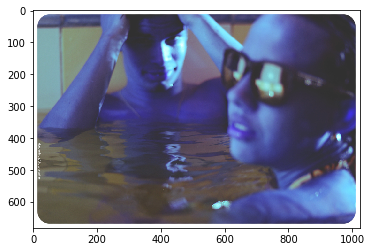

In [62]:
show_image('train/001ca039e68c81ac.jpg')